# LC-MS: All Features Pos 


In [54]:
import pandas as pd
import numpy as np
import os
import openpyxl

# Visualizations 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from scipy.stats import zscore, entropy, f_oneway
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.ensemble import IsolationForest

%matplotlib inline

In [55]:
# set the directory 
os.chdir('/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/Results')

In [56]:
# Define the color palette for the sample types
sample_type_palette = {'Must': '#482677FF', 'PostAF': '#238A8DFF','PostMLF': '#74D055FF'}

# set SNS style
sns.set_style(style="whitegrid")

# 1. Load data

In [57]:
# order
samples = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/FGCZ data/Order_34707_orderitem.csv')

# Extract the list of sample names
sample_names = samples['Sample Name'].tolist()

# Create a new dataframe 'sample_md' with selected column
sample_md = samples[['Sample Name']].copy()
# Split 'Sample Name' into new columns
sample_md[['sample_type', 'year', 'plot']] = sample_md['Sample Name'].str.split('_', expand=True)
sample_md.head()

,Sample Name,sample_type,year,plot
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14
1,PostMLF_2021_Plot9,PostMLF,2021,Plot9
2,PostMLF_2021_Plot15,PostMLF,2021,Plot15
3,PostMLF_2021_Plot12,PostMLF,2021,Plot12
4,PostMLF_2021_Plot17,PostMLF,2021,Plot17


In [58]:
# Get the raw data
file_path = "/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/FGCZ data/p32837_o34707_Lena_RPMetabolomics_ALL_features_POS.xlsx"

# Read only the 'Area_Stats' sheet
df = pd.read_excel(file_path, sheet_name="Area_Stats")

In [59]:
print('Total Features: ' + str(df.shape[0]))
print('Uniquely annotated features: ' + str(df['Name'].notna().sum()))

Total Features: 6205
Uniquely annotated features: 1942


In [60]:
# Fill empty 'Name' values with 'MW_' + corresponding 'Calc. MW' value
df['Name'] = df['Name'].fillna(df.apply(lambda row: f"mz{row['m/z']:.4f}_RT{row['RT [min]']:.2f}" if pd.notna(row['m/z']) and pd.notna(row['RT [min]']) else "Unknown", axis=1))

## SUBSET TO NORMMALIZED SAMPLES 
# Identify 'Norm. Area' columns that correspond to samples in the list
matching_columns = [
    col for col in df.columns
    if any(sample in col for sample in sample_names) and col.startswith('Norm. Area')]# Create a mapping to rename columns by extracting only the sample name
rename_dict = {col: next(sample for sample in sample_names if sample in col) for col in matching_columns}
# Select relevant columns and rename them
df = df[['Name'] + matching_columns].rename(columns=rename_dict)

# Set 'Name' as the index
df.set_index('Name', inplace=True)

df.head()

,Must_2023_Plot20,Must_2023_Plot19,Must_2023_Plot14,Must_2023_Plot17,Must_2023_Plot4,Must_2023_Plot9,Must_2023_Plot5,Must_2023_Plot12,Must_2023_Plot13,Must_2023_Plot15,...,PostMLF_2023_Plot4,PostMLF_2023_Plot15,PostMLF_2023_Plot5,PostMLF_2023_Plot20,PostMLF_2023_Plot17,PostMLF_2023_Plot13,PostMLF_2023_Plot14,PostMLF_2023_Plot19,PostMLF_2023_Plot9,PostMLF_2023_Plot12
Name,,,,,,,,,,,,,,,,,,,,,
mz151.0351_RT0.10,1.032177e+09,9.918709e+08,1.060552e+09,1.204106e+09,1.029715e+09,1.129264e+09,1.106011e+08,9.912120e+08,1.100597e+09,1.248476e+09,...,4.817876e+08,3.935938e+08,5.168420e+08,4.489065e+08,3.986494e+08,4.132504e+08,6.061189e+08,3.952914e+08,5.593264e+08,4.315676e+08
mz169.0456_RT0.10,3.499537e+08,3.062710e+08,3.658447e+08,3.529944e+08,3.087450e+08,3.246923e+08,4.885965e+07,3.281794e+08,3.651248e+08,3.946032e+08,...,1.577158e+08,1.282894e+08,1.641127e+08,1.597561e+08,1.417255e+08,1.467779e+08,2.168822e+06,1.448849e+08,1.951365e+08,1.461857e+08
mz219.0262_RT0.12,7.880012e+08,1.071865e+09,6.907342e+08,7.146140e+08,8.834882e+08,9.503769e+08,2.365683e+08,7.313591e+08,9.342148e+08,7.208672e+08,...,4.208066e+07,8.653881e+07,6.236946e+07,6.914756e+07,1.254820e+08,2.180300e+07,1.085393e+08,2.981520e+07,7.898615e+07,4.153041e+07
mz141.0126_RT0.12,7.001248e+05,8.390605e+05,6.225802e+05,4.170462e+05,4.343865e+05,4.278065e+05,4.275882e+05,7.512533e+05,8.356320e+05,9.136924e+05,...,1.982150e+06,1.290139e+06,3.421547e+06,1.954598e+06,5.319129e+05,1.034943e+06,5.792018e+05,1.119744e+06,5.680902e+05,1.061720e+06
mz190.9791_RT7.19,2.242764e+09,2.140571e+09,1.950499e+09,2.115791e+09,2.180337e+09,2.404078e+09,2.746355e+09,2.366003e+09,1.904476e+09,2.143585e+09,...,9.095932e+08,8.094849e+08,1.011924e+09,7.908102e+08,7.169030e+08,8.348489e+08,1.087321e+09,7.907046e+08,1.048445e+09,8.918962e+08


In [61]:
## MERGE samples with metadata
df = df.T  # Transpose so samples are rows, features are columns
df.index.name = 'Sample Name'

# Merge metadata with metabolomics data
df_wMetadata = sample_md.merge(df, on='Sample Name')

df_wMetadata.head()

,Sample Name,sample_type,year,plot,mz151.0351_RT0.10,mz169.0456_RT0.10,mz219.0262_RT0.12,mz141.0126_RT0.12,mz190.9791_RT7.19,mz149.9526_RT7.19,...,α-Aspartylphenylalanine,α-Aspartylphenylalanine,α-Dehydrobiotin,α-Lactose,α-Methylbiotin,γ-L-glutaminyl-4-hydroxybenzene,γ-L-glutaminyl-4-hydroxybenzene,γ-L-glutamyl-L-leucine,γ-L-glutamyl-L-leucine,γ-Linolenic acid ethyl ester
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14,4.733217e+08,1.458016e+08,1.342342e+07,1.564931e+06,1.034697e+09,1.927616e+08,...,3.477252e+05,2.307151e+06,5.185013e+05,2.296109e+07,266586.780980,251072.362101,4.410323e+05,4.263337e+06,1.322909e+06,4.173555e+05
1,PostMLF_2021_Plot9,PostMLF,2021,Plot9,5.048350e+08,1.425690e+08,8.127907e+06,1.474838e+06,1.020352e+09,1.869808e+08,...,3.858248e+05,1.483529e+06,3.972452e+05,1.512257e+07,247323.219520,398778.250662,7.931905e+05,6.183243e+06,1.323540e+06,3.993300e+05
2,PostMLF_2021_Plot15,PostMLF,2021,Plot15,4.450788e+08,1.287349e+08,1.806459e+07,2.360508e+06,9.307549e+08,1.717203e+08,...,2.608673e+05,1.218210e+06,4.567842e+05,1.592785e+07,225365.199301,230675.566115,3.620907e+05,4.230207e+06,1.438127e+07,4.055137e+05
3,PostMLF_2021_Plot12,PostMLF,2021,Plot12,4.304416e+07,2.246791e+07,3.174929e+05,5.482286e+05,3.310569e+09,6.080512e+08,...,7.083360e+05,9.720946e+05,1.386647e+06,1.368166e+06,806934.139860,234766.960041,8.525567e+05,2.969781e+05,3.918385e+05,1.172564e+06
4,PostMLF_2021_Plot17,PostMLF,2021,Plot17,4.381626e+08,1.209767e+08,5.714480e+06,9.778156e+05,8.204838e+08,1.628189e+08,...,2.356091e+06,2.163101e+06,3.984899e+05,1.621637e+07,231598.531579,502487.358990,1.201365e+06,7.555596e+06,1.314372e+06,3.369838e+05


In [62]:
df_wMetadata.shape

(52, 6209)

In [63]:
# Sum up duplicated Columns: features with the same mz/RT
metadata_columns = ['Sample Name', 'sample_type', 'year', 'plot']

# Separate metadata and data columns
metadata = df_wMetadata[metadata_columns]
data = df_wMetadata.drop(columns=metadata_columns)

# Sum up duplicate columns in the data part
data_summed = data.groupby(data.columns, axis=1).sum()

# Combine metadata and summed data
df_wMetadata = pd.concat([metadata, data_summed], axis=1)

df_wMetadata.shape

/scratch/lfloerl/tmpdata/ipykernel_2448502/1636856459.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data_summed = data.groupby(data.columns, axis=1).sum()


(52, 5773)

### Alpha Diversity 
> check before normalizing 

#### Shannon Entropy

In [64]:
# Shannon entropy calculation
def shannon_entropy(values):
    """Calculate Shannon entropy for a given array of values."""
    # Normalize the values to get probabilities
    value_counts = values.value_counts(normalize=True)
    return entropy(value_counts)

# Function to apply Shannon entropy to the dataframe
def shannon_diversity_df(df):
    """Calculate Shannon Diversity for each column in a DataFrame."""
    shannon_diversity_values = {}
    for column in df.columns:
        shannon_diversity_values[column] = shannon_entropy(df[column])
    return pd.Series(shannon_diversity_values)

In [65]:
 # Apply Shannon entropy calculation to the collapsed data
shannon_diversity_results = df_wMetadata.apply(shannon_entropy, axis=1)

# Add the Shannon diversity values to a new dataframe with 'Sample Type' and 'Year'
shannon_diversity_df = pd.DataFrame({
    'Sample Type': df_wMetadata['sample_type'],  # Assuming 'sample_type' is a column
    'Year': df_wMetadata['year'],  # Assuming 'year' is a column
    'Shannon Diversity': shannon_diversity_results
})

In [66]:
# Group by 'Year' and 'Sample Type' for Shannon index
shannon_grouped = shannon_diversity_df.groupby(['Year', 'Sample Type'])['Shannon Diversity']

# Extract values for each group
group_postMLF_2023_shannon = shannon_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_shannon = shannon_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_shannon = shannon_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('SHANNON postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2022_shannon)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2021_shannon)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2022_shannon, group_postMLF_2021_shannon)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

SHANNON postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 0.050758608405154865
ANOVA 2023 vs 2021 p-value: 0.24062870289716015
ANOVA 2022 vs 2021 p-value: 0.44495660924613


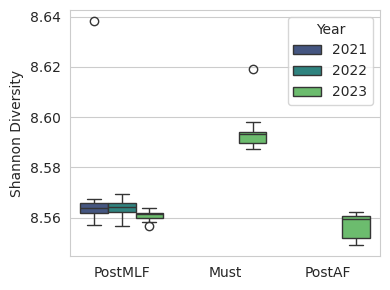

In [67]:
# Plot box plots
plt.figure(figsize=(4, 3))
sns.boxplot(data=shannon_diversity_df, x='Sample Type', y='Shannon Diversity', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Shannon Diversity')
plt.legend(title='Year')
plt.tight_layout() 
plt.show()

#### Richness

In [68]:
def richness(df):
    """Calculate richness (number of unique values) for each row in the DataFrame."""
    return df.apply(lambda x: x.nunique(), axis=1)

In [69]:
# Calculate richness for each sample (row)
richness_values = richness(df_wMetadata.iloc[:, 3:])

# Create a DataFrame with richness values
richness_df = pd.DataFrame(richness_values, columns=['Richness']).reset_index()

# Extract 'Sample Type' and 'Year' from the index or metadata columns
richness_df['Sample Type'] = df_wMetadata['sample_type'].values
richness_df['Year'] = df_wMetadata['year'].values

In [70]:
richness_grouped = richness_df.groupby(['Year', 'Sample Type'])['Richness']

# Extract values for each group
group_postMLF_2023_values = richness_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_values = richness_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_values = richness_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('RICHNESS postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2022_values)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2021_values)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2022_values, group_postMLF_2021_values)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

RICHNESS postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 0.026414310231402453
ANOVA 2023 vs 2021 p-value: 0.24920527856917432
ANOVA 2022 vs 2021 p-value: 0.4852760409533142


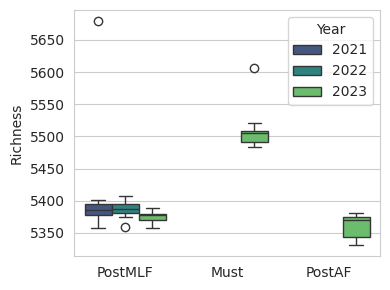

In [71]:
# Plot box plots
plt.figure(figsize=(4, 3))
sns.boxplot(data=richness_df, x='Sample Type', y='Richness', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Richness')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

### Normalize & Transform Data

1. Log Transformation to reduce skewness.
2. Pareto/Auto-scaling (Z-score normalization) for better comparison.

In [72]:
df_wMetadata.iloc[:, 4:] = np.log1p(df_wMetadata.iloc[:, 4:])  # Log transform
scaler = StandardScaler()
df_wMetadata.iloc[:, 4:] = scaler.fit_transform(df_wMetadata.iloc[:, 4:])

df_wMetadata.set_index('Sample Name', inplace=True)

In [73]:
df_wMetadata.shape

(52, 5772)

### Remove outliers

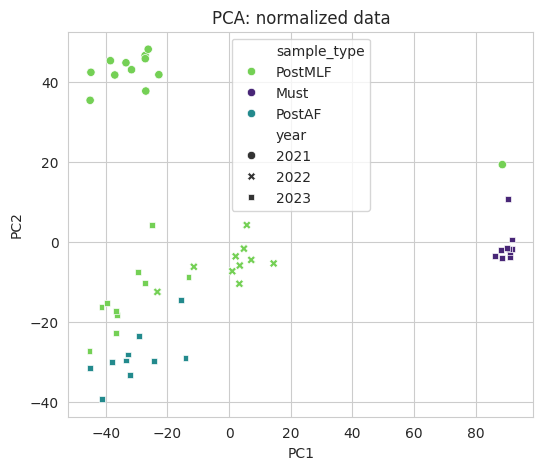

In [74]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_wMetadata.iloc[:, 3:])

df_pca = df_wMetadata[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

sample_type_palette = {'Must': '#482677FF', 'PostAF': '#238A8DFF','PostMLF': '#74D055FF'}

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette=sample_type_palette)
plt.title('PCA: normalized data')
plt.show()


The Post-MLF 2021 samples appear to be outliers - we apply an Isolation Forest to clear this up

> Alternative: Apply Isolation Forest on PCA Scores? 

In [75]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(df_wMetadata.iloc[:, 4:])  # Fit on normalized data

# Remove outliers (label = -1)
df_wMetadata_cleaned = df_wMetadata[outlier_labels == 1]
df_wMetadata_cleaned.shape

(49, 5772)

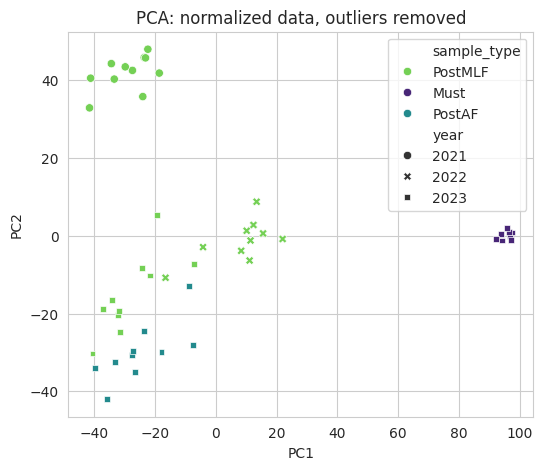

In [76]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_wMetadata_cleaned.iloc[:, 3:])

df_pca = df_wMetadata_cleaned[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette = sample_type_palette)
plt.title('PCA: normalized data, outliers removed')
plt.show()


In [77]:
# save
df_wMetadata_cleaned.to_csv('Pos_All_OutlierRemoved.csv')